# German Credit Risk from training session by Leonardo Ferreira
https://www.kaggle.com/kabure/notebooks

In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

%matplotlib inline

from sklearn.model_selection import (
    train_test_split,
    KFold,
    cross_val_score,
    GridSearchCV,
)
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    fbeta_score,
)
import plotly.graph_objs as go
import plotly.offline as py
from plotly.subplots import make_subplots

py.init_notebook_mode(connected=True)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve

plt.style.use("seaborn-dark")

%reload_ext nb_black

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
df_credit = pd.read_csv("../data/german_credit_data.csv", index_col=0)

<IPython.core.display.Javascript object>

## Exploratory Data Analysis

In [3]:
df_credit.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


<IPython.core.display.Javascript object>

In [4]:
df_credit.shape

(1000, 10)

<IPython.core.display.Javascript object>

In [5]:
df_credit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
Age                 1000 non-null int64
Sex                 1000 non-null object
Job                 1000 non-null int64
Housing             1000 non-null object
Saving accounts     817 non-null object
Checking account    606 non-null object
Credit amount       1000 non-null int64
Duration            1000 non-null int64
Purpose             1000 non-null object
Risk                1000 non-null object
dtypes: int64(4), object(6)
memory usage: 85.9+ KB


<IPython.core.display.Javascript object>

In [6]:
df_credit.nunique()

Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       4
Checking account      3
Credit amount       921
Duration             33
Purpose               8
Risk                  2
dtype: int64

<IPython.core.display.Javascript object>

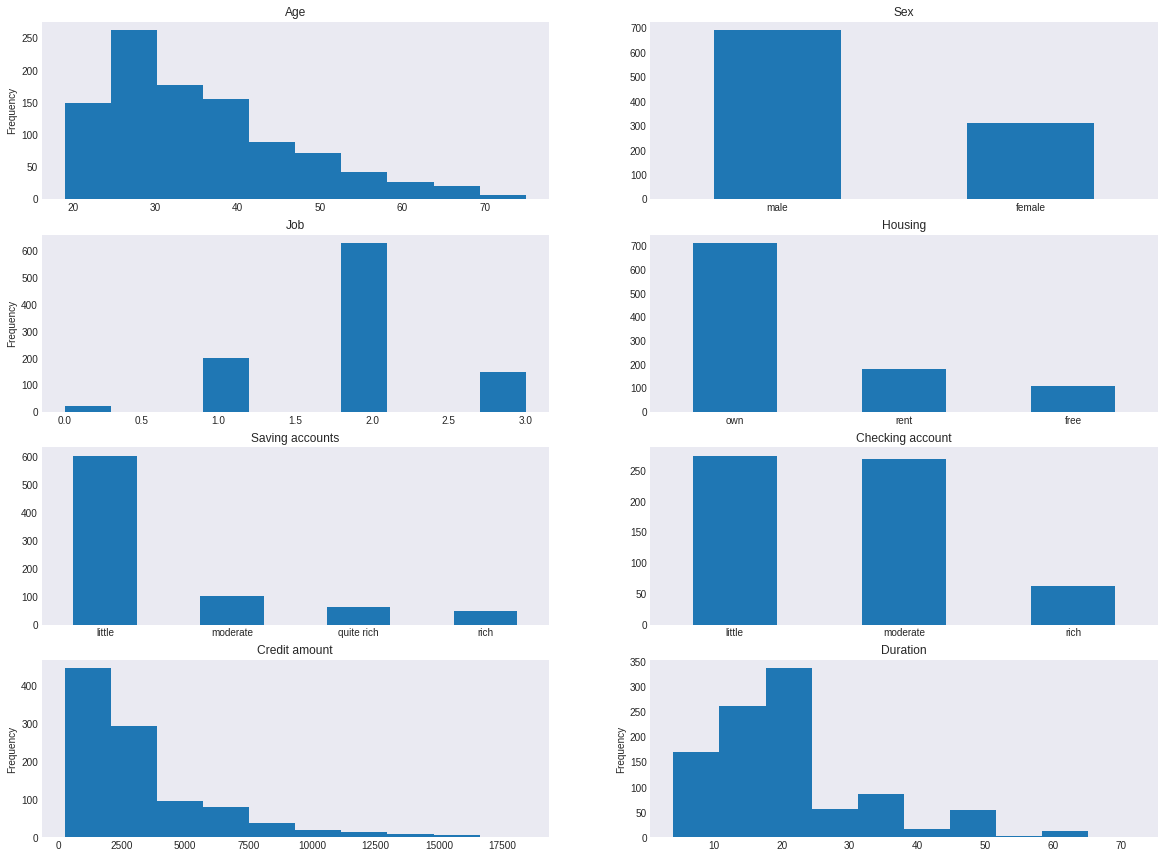

<IPython.core.display.Javascript object>

In [7]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(20, 15))

df_credit["Age"].plot(kind="hist", ax=ax[0][0], title="Age")
df_credit["Sex"].value_counts().plot(kind="bar", ax=ax[0][1], title="Sex", rot=0)
df_credit["Job"].plot(kind="hist", ax=ax[1][0], title="Job")
df_credit["Housing"].value_counts().plot(
    kind="bar", ax=ax[1][1], title="Housing", rot=0
)
df_credit["Saving accounts"].value_counts().plot(
    kind="bar", ax=ax[2][0], title="Saving accounts", rot=0
)
df_credit["Checking account"].value_counts().plot(
    kind="bar", ax=ax[2][1], title="Checking account", rot=0
)
df_credit["Credit amount"].plot(kind="hist", ax=ax[3][0], title="Credit amount")
df_credit["Duration"].plot(kind="hist", ax=ax[3][1], title="Duration")

plt.show()

In [8]:
trace0 = go.Bar(
    x=df_credit[df_credit["Risk"] == "good"]["Risk"].value_counts().index.values,
    y=df_credit[df_credit["Risk"] == "good"]["Risk"].value_counts().values,
    name="Good credit",
)

trace1 = go.Bar(
    x=df_credit[df_credit["Risk"] == "bad"]["Risk"].value_counts().index.values,
    y=df_credit[df_credit["Risk"] == "bad"]["Risk"].value_counts().values,
    name="Bad credit",
)

data = [trace0, trace1]

layout = go.Layout()

layout = go.Layout(
    yaxis=dict(title="Count"),
    xaxis=dict(title="Risk Variable"),
    title="Target variable distribution",
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename="grouped-bar")

<IPython.core.display.Javascript object>

In [9]:
df_good = df_credit.loc[df_credit["Risk"] == "good"]["Age"].values.tolist()
df_bad = df_credit.loc[df_credit["Risk"] == "bad"]["Age"].values.tolist()
df_age = df_credit["Age"].values.tolist()

# First plot
trace0 = go.Histogram(x=df_good, histnorm="probability", name="Good Credit")
# Second plot
trace1 = go.Histogram(x=df_bad, histnorm="probability", name="Bad Credit")
# Third plot
trace2 = go.Histogram(x=df_age, histnorm="probability", name="Overall Age")

# Creating the grid
fig = make_subplots(
    rows=2,
    cols=2,
    specs=[[{}, {}], [{"colspan": 2}, None]],
    subplot_titles=("Good", "Bad", "General Distribuition"),
)

# setting the figs
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace2, 2, 1)

fig["layout"].update(showlegend=True, title="Age Distribuition", bargap=0.05)
py.iplot(fig, filename="custom-sized-subplot-with-subplot-titles")

<IPython.core.display.Javascript object>

/home/rahul/Projects/EPA/venv_epa/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



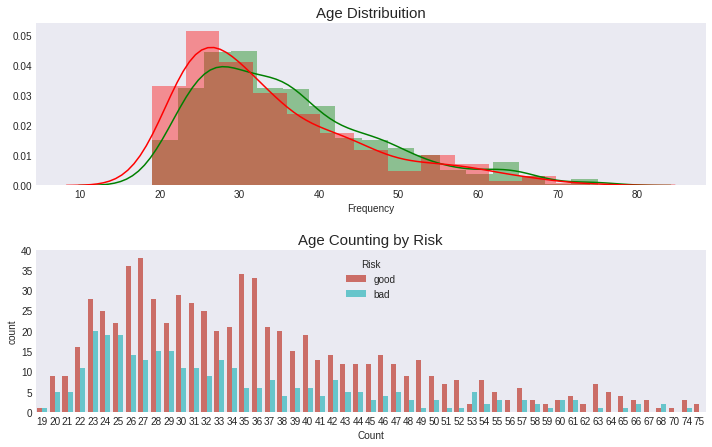

<IPython.core.display.Javascript object>

In [10]:
df_good = df_credit[df_credit["Risk"] == "good"]
df_bad = df_credit[df_credit["Risk"] == "bad"]

fig, ax = plt.subplots(nrows=2, figsize=(12, 8))
plt.subplots_adjust(hspace=0.4, top=0.8)

g1 = sns.distplot(df_good["Age"], ax=ax[0], color="g")
g1 = sns.distplot(df_bad["Age"], ax=ax[0], color="r")
g1.set_title("Age Distribuition", fontsize=15)
g1.set_xlabel("Age")
g1.set_xlabel("Frequency")

g2 = sns.countplot(x="Age", data=df_credit, palette="hls", ax=ax[1], hue="Risk")
g2.set_title("Age Counting by Risk", fontsize=15)
g2.set_xlabel("Age")
g2.set_xlabel("Count")
plt.show()

#### Turning Age to a categorical feature based on Age-Range

In [11]:
Ranges = [18, 25, 35, 60, 120]
Categories = ["Student", "Young", "Adult", "Senior"]

df_credit["Age_Category"] = pd.cut(df_credit.Age, Ranges, labels=Categories)

<IPython.core.display.Javascript object>

In [12]:
df_good = df_credit[df_credit["Risk"] == "good"]
df_bad = df_credit[df_credit["Risk"] == "bad"]

trace0 = go.Box(
    y=df_good["Credit amount"],
    x=df_good["Age_Category"],
    name="Good credit",
    marker=dict(color="#3D9970"),
)

trace1 = go.Box(
    y=df_bad["Credit amount"],
    x=df_bad["Age_Category"],
    name="Bad credit",
    marker=dict(color="#FF4136"),
)

data = [trace0, trace1]

layout = go.Layout(
    yaxis=dict(title="Credit Amount (US Dollar)", zeroline=False),
    xaxis=dict(title="Age_Category"),
    boxmode="group",
)
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename="box-age-cat")

<IPython.core.display.Javascript object>

In [13]:
# First plot
trace0 = go.Bar(
    x=df_credit[df_credit["Risk"] == "good"]["Housing"].value_counts().index.values,
    y=df_credit[df_credit["Risk"] == "good"]["Housing"].value_counts().values,
    name="Good credit",
)

# Second plot
trace1 = go.Bar(
    x=df_credit[df_credit["Risk"] == "bad"]["Housing"].value_counts().index.values,
    y=df_credit[df_credit["Risk"] == "bad"]["Housing"].value_counts().values,
    name="Bad Credit",
)

data = [trace0, trace1]

layout = go.Layout(title="Housing Distribution")
fig = go.Figure(data=data, layout=layout)

py.iplot(fig)

<IPython.core.display.Javascript object>

In [14]:
# First plot
trace0 = go.Bar(
    x=df_credit[df_credit["Risk"] == "good"]["Sex"].value_counts().index.values,
    y=df_credit[df_credit["Risk"] == "good"]["Sex"].value_counts().values,
    name="Good credit",
)

# First plot 2
trace1 = go.Bar(
    x=df_credit[df_credit["Risk"] == "bad"]["Sex"].value_counts().index.values,
    y=df_credit[df_credit["Risk"] == "bad"]["Sex"].value_counts().values,
    name="Bad Credit",
)

# Second plot
trace2 = go.Box(
    x=df_credit[df_credit["Risk"] == "good"]["Sex"],
    y=df_credit[df_credit["Risk"] == "good"]["Credit amount"],
    name=trace0.name,
)

# Second plot 2
trace3 = go.Box(
    x=df_credit[df_credit["Risk"] == "bad"]["Sex"],
    y=df_credit[df_credit["Risk"] == "bad"]["Credit amount"],
    name=trace1.name,
)

data = [trace0, trace1, trace2, trace3]


fig = make_subplots(
    rows=1, cols=2, subplot_titles=("Sex Count", "Credit Amount by Sex")
)

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 2)

fig["layout"].update(height=400, width=800, title="Sex Distribuition", boxmode="group")
py.iplot(fig, filename="sex-subplot")

<IPython.core.display.Javascript object>

In [15]:
# First plot
trace0 = go.Bar(
    x=df_credit[df_credit["Risk"] == "good"]["Job"].value_counts().index.values,
    y=df_credit[df_credit["Risk"] == "good"]["Job"].value_counts().values,
    name="Good credit Distribuition",
)

# Second plot
trace1 = go.Bar(
    x=df_credit[df_credit["Risk"] == "bad"]["Job"].value_counts().index.values,
    y=df_credit[df_credit["Risk"] == "bad"]["Job"].value_counts().values,
    name="Bad Credit Distribuition",
)

data = [trace0, trace1]

layout = go.Layout(title="Job Distribuition")

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename="grouped-bar")

<IPython.core.display.Javascript object>

In [16]:
trace0 = go.Box(x=df_good["Job"], y=df_good["Credit amount"], name="Good credit")

trace1 = go.Box(x=df_bad["Job"], y=df_bad["Credit amount"], name="Bad credit")

data = [trace0, trace1]

layout = go.Layout(
    yaxis=dict(title="Credit Amount distribuition by Job"), boxmode="group"
)
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename="box-age-cat")

<IPython.core.display.Javascript object>

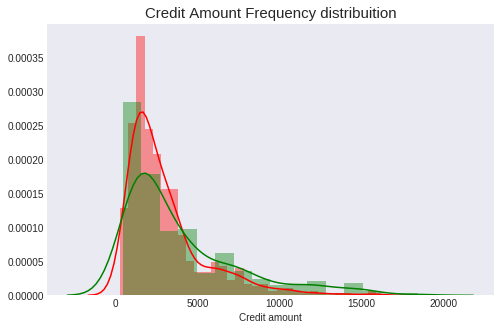

<IPython.core.display.Javascript object>

In [17]:
plt.figure(figsize=(8, 5))

g = sns.distplot(df_good["Credit amount"], color="r")
g = sns.distplot(df_bad["Credit amount"], color="g")
g.set_title("Credit Amount Frequency distribuition", fontsize=15)
plt.show()

In [18]:
from plotly import tools
import numpy as np
import plotly.graph_objs as go

count_good = go.Bar(
    x = df_good["Saving accounts"].value_counts().index.values,
    y = df_good["Saving accounts"].value_counts().values,
    name='Good credit'
)
count_bad = go.Bar(
    x = df_bad["Saving accounts"].value_counts().index.values,
    y = df_bad["Saving accounts"].value_counts().values,
    name='Bad credit'
)


box_1 = go.Box(
    x=df_good["Saving accounts"],
    y=df_good["Credit amount"],
    name='Good credit'
)
box_2 = go.Box(
    x=df_bad["Saving accounts"],
    y=df_bad["Credit amount"],
    name='Bad credit'
)

scat_1 = go.Box(
    x=df_good["Saving accounts"],
    y=df_good["Age"],
    name='Good credit'
)
scat_2 = go.Box(
    x=df_bad["Saving accounts"],
    y=df_bad["Age"],
    name='Bad credit'
)

data = [scat_1, scat_2, box_1, box_2, count_good, count_bad]

fig = make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                          subplot_titles=('Count Saving Accounts','Credit Amount by Savings Acc', 
                                          'Age by Saving accounts'))

fig.append_trace(count_good, 1, 1)
fig.append_trace(count_bad, 1, 1)

fig.append_trace(box_2, 1, 2)
fig.append_trace(box_1, 1, 2)

fig.append_trace(scat_1, 2, 1)
fig.append_trace(scat_2, 2, 1)



fig['layout'].update(height=700, width=800, title='Saving Accounts Exploration', boxmode='group')

py.iplot(fig, filename='combined-savings')


<IPython.core.display.Javascript object>

Values describe: 
Risk                 bad  good
Purpose                       
business              34    63
car                  106   231
domestic appliances    4     8
education             23    36
furniture/equipment   58   123
radio/TV              62   218
repairs                8    14
vacation/others        5     7


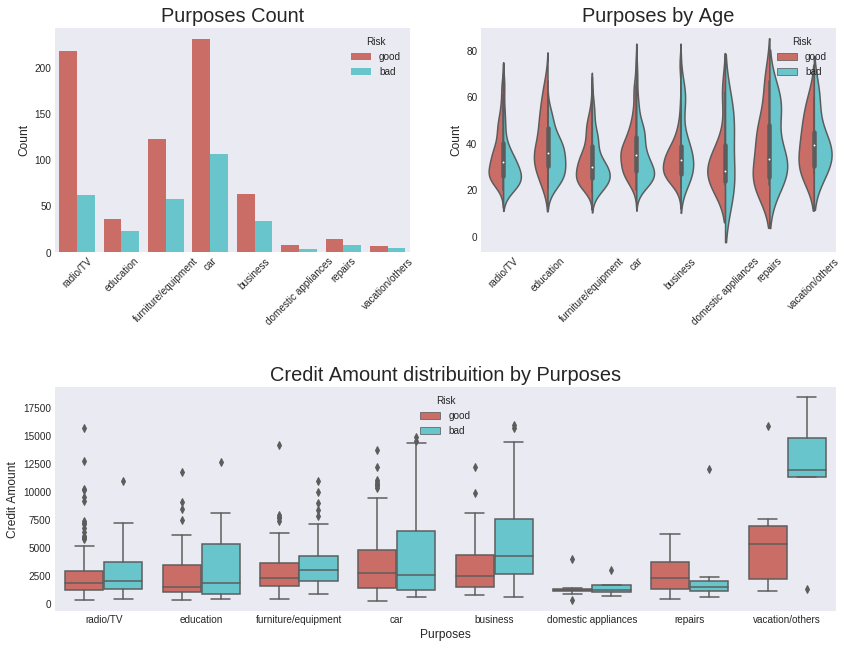

<IPython.core.display.Javascript object>

In [19]:
print("Values describe: ")
print(pd.crosstab(df_credit.Purpose, df_credit.Risk))

plt.figure(figsize=(14, 12))

plt.subplot(221)
g = sns.countplot(x="Purpose", data=df_credit, palette="hls", hue="Risk")
g.set_xticklabels(g.get_xticklabels(), rotation=45)
g.set_xlabel("", fontsize=12)
g.set_ylabel("Count", fontsize=12)
g.set_title("Purposes Count", fontsize=20)

plt.subplot(222)
g1 = sns.violinplot(
    x="Purpose", y="Age", data=df_credit, palette="hls", hue="Risk", split=True
)
g1.set_xticklabels(g1.get_xticklabels(), rotation=45)
g1.set_xlabel("", fontsize=12)
g1.set_ylabel("Count", fontsize=12)
g1.set_title("Purposes by Age", fontsize=20)

plt.subplot(212)
g2 = sns.boxplot(
    x="Purpose", y="Credit amount", data=df_credit, palette="hls", hue="Risk"
)
g2.set_xlabel("Purposes", fontsize=12)
g2.set_ylabel("Credit Amount", fontsize=12)
g2.set_title("Credit Amount distribuition by Purposes", fontsize=20)

plt.subplots_adjust(hspace=0.6, top=0.8)

plt.show()

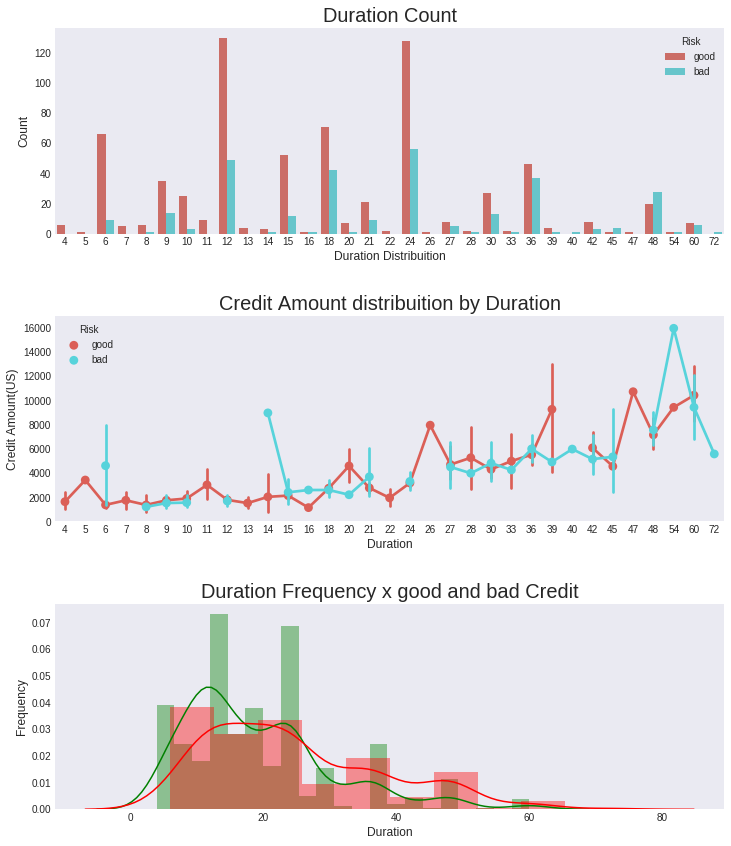

<IPython.core.display.Javascript object>

In [20]:
plt.figure(figsize=(12, 14))

g = plt.subplot(311)
g = sns.countplot(x="Duration", data=df_credit, palette="hls", hue="Risk")
g.set_xlabel("Duration Distribuition", fontsize=12)
g.set_ylabel("Count", fontsize=12)
g.set_title("Duration Count", fontsize=20)

g1 = plt.subplot(312)
g1 = sns.pointplot(
    x="Duration", y="Credit amount", data=df_credit, hue="Risk", palette="hls"
)
g1.set_xlabel("Duration", fontsize=12)
g1.set_ylabel("Credit Amount(US)", fontsize=12)
g1.set_title("Credit Amount distribuition by Duration", fontsize=20)

g2 = plt.subplot(313)
g2 = sns.distplot(df_good["Duration"], color="g")
g2 = sns.distplot(df_bad["Duration"], color="r")
g2.set_xlabel("Duration", fontsize=12)
g2.set_ylabel("Frequency", fontsize=12)
g2.set_title("Duration Frequency x good and bad Credit", fontsize=20)

plt.subplots_adjust(wspace=0.4, hspace=0.4, top=0.9)

plt.show()

In [21]:
# First plot
trace0 = go.Bar(
    x=df_credit[df_credit["Risk"] == "good"]["Checking account"]
    .value_counts()
    .index.values,
    y=df_credit[df_credit["Risk"] == "good"]["Checking account"].value_counts().values,
    name="Good credit Distribuition",
)

# Second plot
trace1 = go.Bar(
    x=df_credit[df_credit["Risk"] == "bad"]["Checking account"]
    .value_counts()
    .index.values,
    y=df_credit[df_credit["Risk"] == "bad"]["Checking account"].value_counts().values,
    name="Bad Credit Distribuition",
)

data = [trace0, trace1]

layout = go.Layout(
    title="Checking accounts Distribuition",
    xaxis=dict(title="Checking accounts name"),
    yaxis=dict(title="Count"),
    barmode="group",
)


fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename="Age-ba", validate=False)

<IPython.core.display.Javascript object>

In [22]:
df_good = df_credit[df_credit["Risk"] == "good"]
df_bad = df_credit[df_credit["Risk"] == "bad"]

trace0 = go.Box(
    y=df_good["Credit amount"],
    x=df_good["Checking account"],
    name="Good credit",
    marker=dict(color="#3D9970"),
)

trace1 = go.Box(
    y=df_bad["Credit amount"],
    x=df_bad["Checking account"],
    name="Bad credit",
    marker=dict(color="#FF4136"),
)

data = [trace0, trace1]

layout = go.Layout(yaxis=dict(title="Cheking distribuition"), boxmode="group")
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename="box-age-cat")

<IPython.core.display.Javascript object>

Total values of the most missing variable: 
Checking account
little      274
moderate    269
rich         63
Name: Checking account, dtype: int64


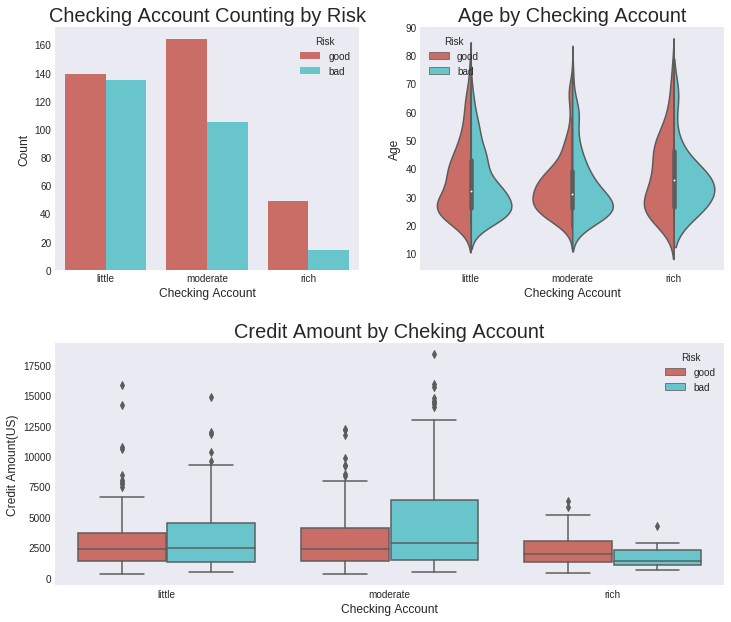

<IPython.core.display.Javascript object>

In [23]:
print("Total values of the most missing variable: ")
print(df_credit.groupby("Checking account")["Checking account"].count())

plt.figure(figsize=(12, 10))

g = plt.subplot(221)
g = sns.countplot(x="Checking account", data=df_credit, palette="hls", hue="Risk")
g.set_xlabel("Checking Account", fontsize=12)
g.set_ylabel("Count", fontsize=12)
g.set_title("Checking Account Counting by Risk", fontsize=20)

g1 = plt.subplot(222)
g1 = sns.violinplot(
    x="Checking account", y="Age", data=df_credit, palette="hls", hue="Risk", split=True
)
g1.set_xlabel("Checking Account", fontsize=12)
g1.set_ylabel("Age", fontsize=12)
g1.set_title("Age by Checking Account", fontsize=20)

g2 = plt.subplot(212)
g2 = sns.boxplot(
    x="Checking account", y="Credit amount", data=df_credit, hue="Risk", palette="hls"
)
g2.set_xlabel("Checking Account", fontsize=12)
g2.set_ylabel("Credit Amount(US)", fontsize=12)
g2.set_title("Credit Amount by Cheking Account", fontsize=20)

plt.subplots_adjust(wspace=0.2, hspace=0.3, top=0.9)

plt.show()
plt.show()

In [24]:
date_int = ["Purpose", "Sex"]
cm = sns.light_palette("green", as_cmap=True)
pd.crosstab(df_credit[date_int[0]], df_credit[date_int[1]]).style.background_gradient(
    cmap=cm
)

Sex,female,male
Purpose,,
business,19,78
car,94,243
domestic appliances,6,6
education,24,35
furniture/equipment,74,107
radio/TV,85,195
repairs,5,17
vacation/others,3,9


<IPython.core.display.Javascript object>

In [25]:
pd.crosstab(df_credit["Checking account"], df_credit.Sex)

Sex,female,male
Checking account,,
little,88,186
moderate,86,183
rich,20,43


<IPython.core.display.Javascript object>

## Feature Engineering

### One hot encode categorical values

In [26]:
df_credit['Saving accounts'] = df_credit['Saving accounts'].fillna('no_inf')
df_credit['Checking account'] = df_credit['Checking account'].fillna('no_inf')


<IPython.core.display.Javascript object>

In [28]:
df_credit = df_credit.merge(
    pd.get_dummies(df_credit.Purpose, drop_first=True, prefix="Purpose"),
    left_index=True,
    right_index=True,
)
# Sex feature in dummies
df_credit = df_credit.merge(
    pd.get_dummies(df_credit.Sex, drop_first=True, prefix="Sex"),
    left_index=True,
    right_index=True,
)
# Housing get dummies
df_credit = df_credit.merge(
    pd.get_dummies(df_credit.Housing, drop_first=True, prefix="Housing"),
    left_index=True,
    right_index=True,
)
# Housing get Saving Accounts
df_credit = df_credit.merge(
    pd.get_dummies(df_credit["Saving accounts"], drop_first=True, prefix="Savings"),
    left_index=True,
    right_index=True,
)
# Housing get Risk
df_credit = df_credit.merge(
    pd.get_dummies(df_credit.Risk, prefix="Risk"), left_index=True, right_index=True
)
# Housing get Checking Account
df_credit = df_credit.merge(
    pd.get_dummies(df_credit["Checking account"], drop_first=True, prefix="Check"),
    left_index=True,
    right_index=True,
)
# Housing get Age categorical
df_credit = df_credit.merge(
    pd.get_dummies(df_credit["Age_Category"], drop_first=True, prefix="Age_cat"),
    left_index=True,
    right_index=True,
)

<IPython.core.display.Javascript object>

In [29]:
df_credit.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,...,Savings_quite rich,Savings_rich,Risk_bad,Risk_good,Check_moderate,Check_no_inf,Check_rich,Age_cat_Young,Age_cat_Adult,Age_cat_Senior
0,67,male,2,own,no_inf,little,1169,6,radio/TV,good,...,0,0,0,1,0,0,0,0,0,1
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad,...,0,0,1,0,1,0,0,0,0,0
2,49,male,1,own,little,no_inf,2096,12,education,good,...,0,0,0,1,0,1,0,0,1,0
3,45,male,2,free,little,little,7882,42,furniture/equipment,good,...,0,0,0,1,0,0,0,0,1,0
4,53,male,2,free,little,little,4870,24,car,bad,...,0,0,1,0,0,0,0,0,1,0


<IPython.core.display.Javascript object>

In [31]:
df_credit = df_credit.drop(
    columns=[
        "Saving accounts",
        "Checking account",
        "Purpose",
        "Sex",
        "Housing",
        "Age_Category",
        "Risk",
        "Risk_good",
    ],
)

<IPython.core.display.Javascript object>

In [36]:
df_credit["Credit amount"] = np.log(df_credit["Credit amount"])

<IPython.core.display.Javascript object>

### Correlation

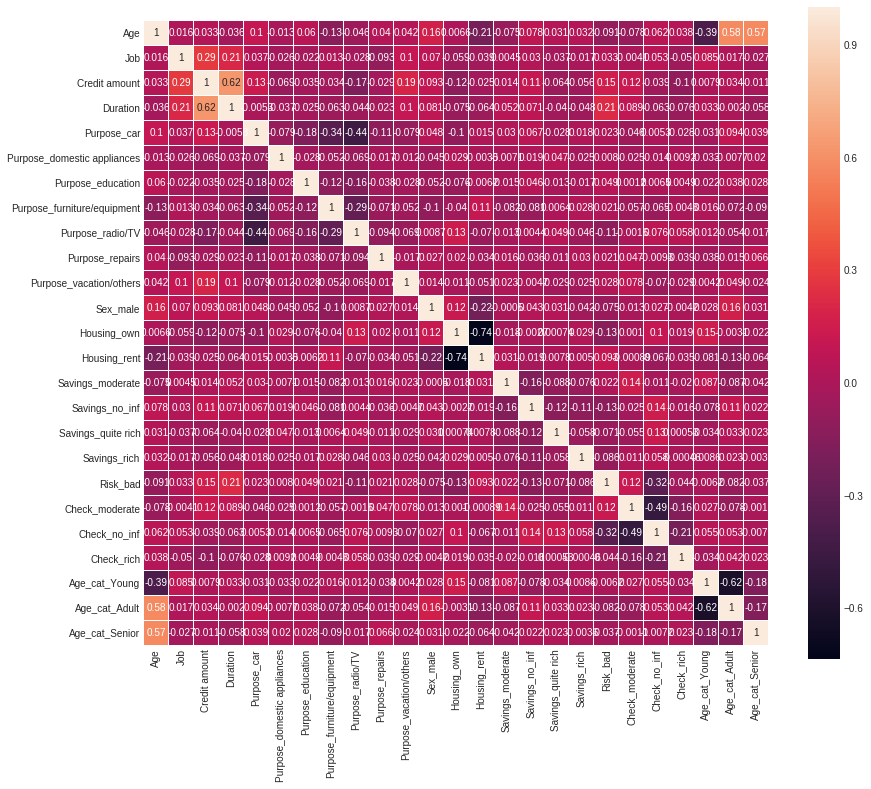

<IPython.core.display.Javascript object>

In [35]:
plt.figure(figsize=(14, 12))
sns.heatmap(
    df_credit.astype(float).corr(),
    linewidths=0.1,
    vmax=1.0,
    square=True,
    linecolor="white",
    annot=True,
)
plt.show()

### Train/Test Split

In [42]:
X = df_credit.drop(columns=["Risk_bad"]).values
y = df_credit["Risk_bad"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

<IPython.core.display.Javascript object>

## Model

In [44]:
seed = 7

models = []

models.append(("LR", LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('TREE', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('XGB', XGBClassifier()))


<IPython.core.display.Javascript object>

In [45]:
results = []
names = []

scoring = "recall"

for name, model in models:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print(
        "Model:",
        name,
        "CV Mean Recall Score:",
        cv_results.mean(),
        "CV STD Recall Score:",
        cv_results.std(),
    )

Model: LR CV Mean Recall Score: 0.38757422363474603 CV STD Recall Score: 0.07797017846051932
Model: LDA CV Mean Recall Score: 0.4288153878650407 CV STD Recall Score: 0.09316227259247405
Model: TREE CV Mean Recall Score: 0.5466397766313926 CV STD Recall Score: 0.09801949677234802
Model: NB CV Mean Recall Score: 0.5962997587178919 CV STD Recall Score: 0.0813648707766421
Model: RF CV Mean Recall Score: 0.3469295545608376 CV STD Recall Score: 0.07741868389886983
Model: SVM CV Mean Recall Score: 0.18222970651835166 CV STD Recall Score: 0.08846165129382097


/home/rahul/Projects/EPA/venv_epa/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/home/rahul/Projects/EPA/venv_epa/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/home/rahul/Projects/EPA/venv_epa/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/home/rahul/Projects/EPA/venv_epa/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of a

Model: XGB CV Mean Recall Score: 0.42291655303964937 CV STD Recall Score: 0.11054986133399064


/home/rahul/Projects/EPA/venv_epa/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/home/rahul/Projects/EPA/venv_epa/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/home/rahul/Projects/EPA/venv_epa/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/home/rahul/Projects/EPA/venv_epa/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of a

<IPython.core.display.Javascript object>

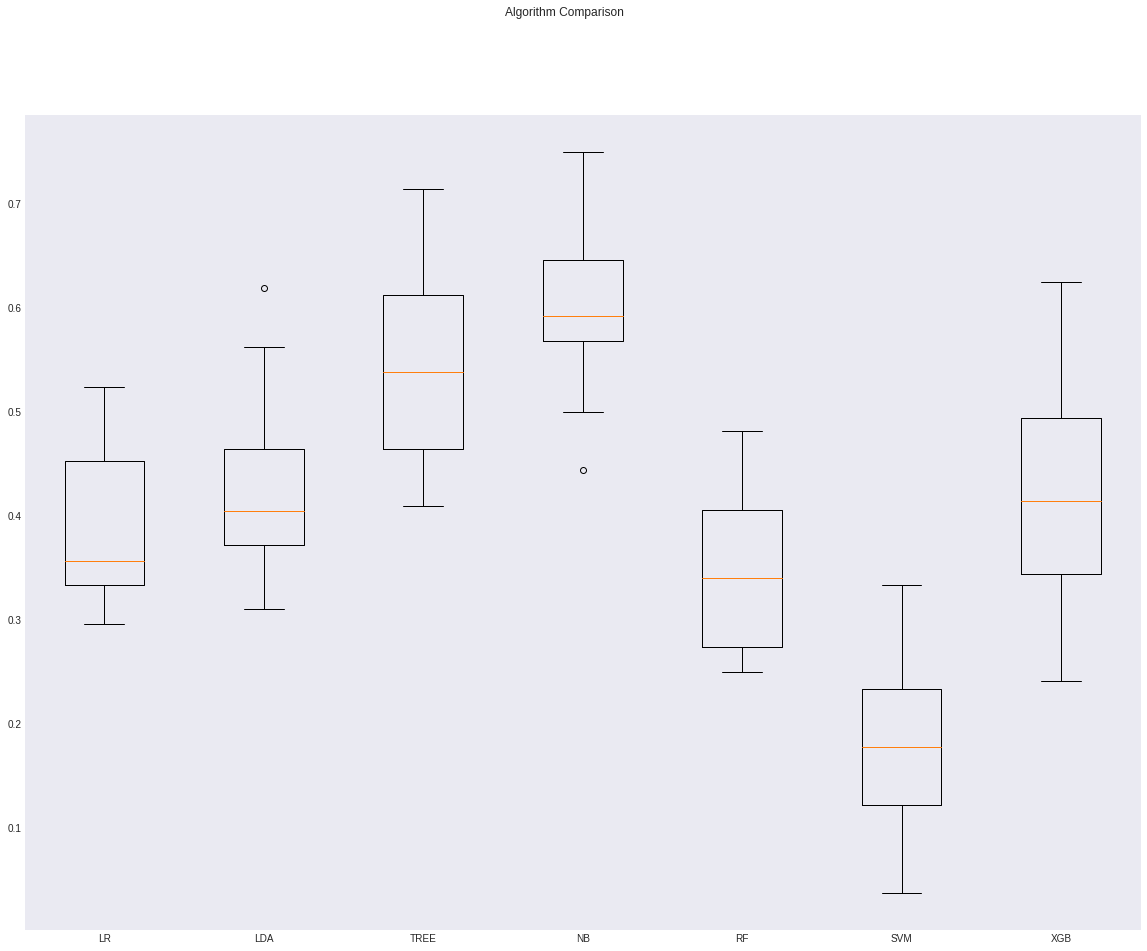

<IPython.core.display.Javascript object>

In [49]:
fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(111)
fig.suptitle("Algorithm Comparison")


plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## Tuning

### Random Forest

In [ ]:
params = {
    "max_depth": [3, 5, 7, 10],
    "n_estimators": [3, 5, 10, 25, 50, 150],
    "max_features": [4, 7, 15, 20],
}

rf_classifier = RandomForestClassifier(random_state=10)

grid_search = GridSearchCV(model, param_grid=params, cv=5, scoring="recall", verbose=0)
grid_search.fit(X_train, y_train)

In [54]:
print(grid_search.best_score_)
print(grid_search.best_params_)

0.491197423510467
{'max_depth': 10, 'max_features': 4, 'n_estimators': 150}


<IPython.core.display.Javascript object>

In [55]:
rf_clf = RandomForestClassifier(max_depth=10, max_features=4, n_estimators=150)

rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=4, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

<IPython.core.display.Javascript object>

In [56]:
y_pred = rf_clf.predict(X_test)

<IPython.core.display.Javascript object>

In [60]:
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.724
[[162  16]
 [ 53  19]]
             precision    recall  f1-score   support

          0       0.75      0.91      0.82       178
          1       0.54      0.26      0.36        72

avg / total       0.69      0.72      0.69       250



<IPython.core.display.Javascript object>

### Naive Bayes

In [61]:
gnb = GaussianNB()

gnb_clf = gnb.fit(X_train, y_train)

<IPython.core.display.Javascript object>

In [74]:
gnb_y_prob = gnb_clf.predict_proba(X_test)[:, 1]
gnb_y_pred = gnb_clf.predict(X_test)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [75]:
print(accuracy_score(y_test, gnb_y_pred))
print(confusion_matrix(y_test, gnb_y_pred))
print(classification_report(y_test, gnb_y_pred))

0.648
[[124  54]
 [ 34  38]]
             precision    recall  f1-score   support

          0       0.78      0.70      0.74       178
          1       0.41      0.53      0.46        72

avg / total       0.68      0.65      0.66       250



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

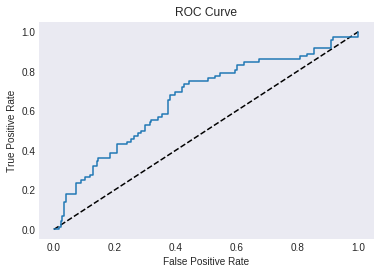

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [78]:
fpr, tpr, thresholds = roc_curve(y_test, gnb_y_prob)

plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

### XGBoost

In [ ]:
xgb_params = {
    "max_depth": [3, 5, 7, 10],
    "min_child_weight": [3, 5, 10],
    "gamma": [0.0, 0.1, 0.2, 0.3, 0.4],
    "sub_sample": [0.75, 0.95, 0.5],
    "colsample_by_tree": [0.75, 0.95, 0.5],
}

xgb_classifier = XGBClassifier(random_state=10)

grid_search = GridSearchCV(
    xgb_classifier, param_grid=xgb_params, cv=5, scoring="recall", verbose=4
)
grid_search.fit(X_train, y_train)

In [85]:
print(grid_search.best_score_)
print(grid_search.best_params_)

0.47808695652173916
{'colsample_by_tree': 0.75, 'gamma': 0.0, 'max_depth': 7, 'min_child_weight': 3, 'sub_sample': 0.75}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [87]:
xgb_clf = XGBClassifier(
    **{
        "colsample_by_tree": 0.75,
        "gamma": 0.0,
        "max_depth": 7,
        "min_child_weight": 3,
        "sub_sample": 0.75,
    }
)

xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_by_tree=0.75,
       colsample_bylevel=1, colsample_bytree=1, gamma=0.0,
       learning_rate=0.1, max_delta_step=0, max_depth=7,
       min_child_weight=3, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, sub_sample=0.75, subsample=1)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [88]:
xgb_y_pred = xgb_clf.predict(X_test)

/home/rahul/Projects/EPA/venv_epa/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [89]:
print(accuracy_score(y_test, xgb_y_pred))
print(confusion_matrix(y_test, xgb_y_pred))
print(classification_report(y_test, xgb_y_pred))

0.748
[[158  20]
 [ 43  29]]
             precision    recall  f1-score   support

          0       0.79      0.89      0.83       178
          1       0.59      0.40      0.48        72

avg / total       0.73      0.75      0.73       250



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [94]:
xgb_y_pred_prob = xgb_clf.predict_proba(X_test)[:, 1]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

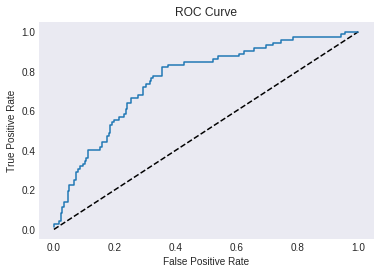

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [96]:
fpr, tpr, thresholds = roc_curve(y_test, xgb_y_pred_prob)

plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()